# Architectures and loss functions for segmentation

In this tutorial we will train a neural network to perform cellular segmentation on fluorescent images of cultured neurons ([link](https://www.cellimagelibrary.org/images/CCDB_6843)).

We will use the most commonly used neural network architecture for segmentation, the U-net (Ronneberger, Fischer & Brox 2015, [paper](https://arxiv.org/pdf/1505.04597)).

We will train the u-net to predict various functions of the labeled cellular images:
* foreground + background pixels (binary cross-entropy loss)
* foreground + background + boundary pixels (cross-entropy loss)
* flow-based representation (from [cellpose](), MSE loss)

# 0. Setup

Install the required packages for cellpose; remove the `--no-deps` flag if you are installing locally rather than on google colab.

In [ ]:
!pip install fastremap
!pip install fill_voids
!pip install roifile
!pip install segment-anything
!pip install cellpose --no-deps


We will import the necessary libraries and download the dataset.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
from torch import nn
import cv2
from cellpose import utils
import zipfile
from pathlib import Path

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# download train and test zips
urls = ['https://osf.io/download/687e1bc261b823b66002c312/',
        'https://osf.io/download/687e1bb840119ec55f1f6406/']
cached_files = [Path('cil_train.zip'), Path('cil_test.zip')]
for url, cached_file in zip(urls, cached_files):
    if not cached_file.exists():
        utils.download_url_to_file(url, cached_file)
        with zipfile.ZipFile(cached_file,"r") as zip_ref:
            zip_ref.extractall('.')




Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




Load in the train and test images:

In [3]:
# load in the images
imgs, masks = [], []
imgs_test, masks_test = [], []
for tstr in ['cil_train', 'cil_test']:
    nimg = 89 if tstr == 'cil_train' else 11
    for i in range(nimg):
        img = cv2.imread(f'{tstr}/{i:03d}_img.png')
        img = img.transpose(2, 0, 1)  # change to channel first
        img = img.astype('float32') # convert to float32
        img /= 255.0
        mask = cv2.imread(f'{tstr}/{i:03d}_masks.png', -1)
        if tstr == 'cil_train':
            imgs.append(img)
            masks.append(mask)
        else:
            imgs_test.append(img)
            masks_test.append(mask)

# convert list to numpy array (all images are the same size)
imgs = np.array(imgs)
masks = np.array(masks)
imgs_test = np.array(imgs_test)
masks_test = np.array(masks_test)

Visualize some example images:

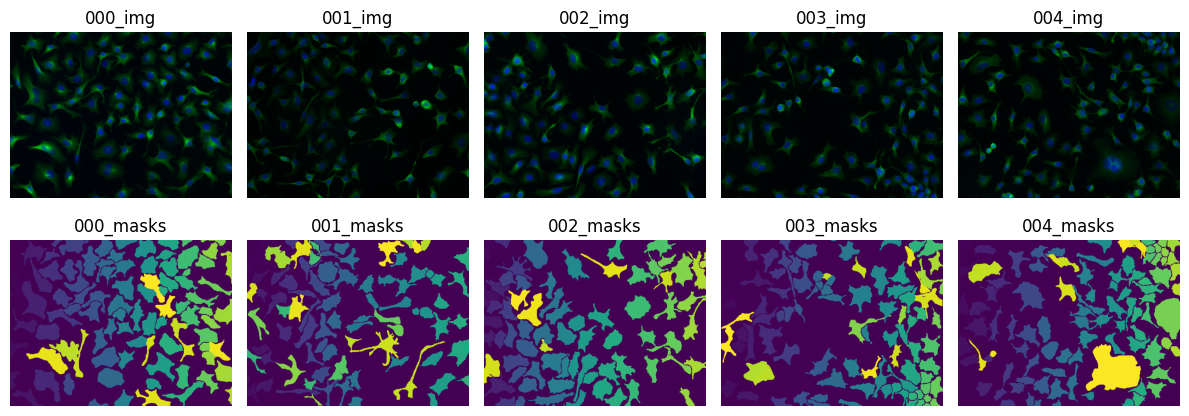

In [4]:
plt.figure(figsize=(12, 4.5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i].transpose(1, 2, 0))  # change to channel last for display
    plt.title(f'{i:03d}_img')
    plt.axis('off')
    plt.subplot(2, 5, i + 6)
    plt.imshow(masks[i])
    plt.title(f'{i:03d}_masks')
    plt.axis('off')
plt.tight_layout()

For augmentations we will use the [`transforms.random_rotate_and_resize`]() function from the Cellpose library. This function randomly resizes the image within a scale range, i.e. for a scale range of 0.5 the images are rescaled between 0.75x and 1.25x. It also randomly rotates and crops the image. You can re-run the following cell to see different random augmentations of each image:

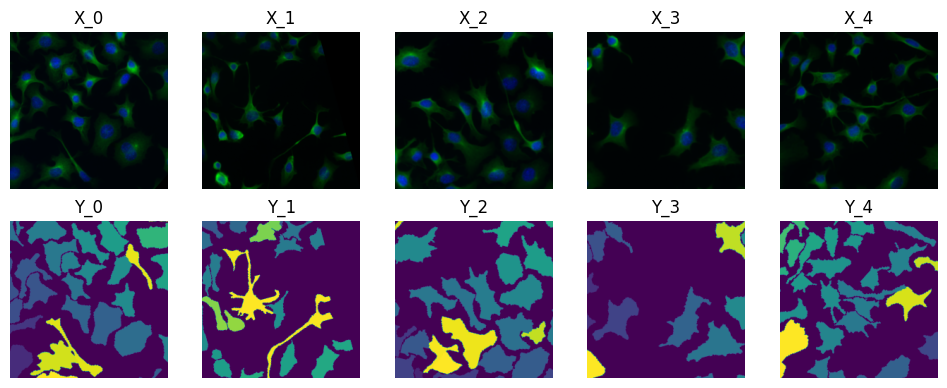

In [5]:
from cellpose import transforms

X, Y, rsz = transforms.random_rotate_and_resize(imgs[:5], masks[:5], scale_range=0.5, xy=(224, 224))

plt.figure(figsize=(12, 4.5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i].transpose(1, 2, 0))  # change to channel last for display
    plt.title(f'X_{i}')
    plt.axis('off')
    plt.subplot(2, 5, i + 6)
    plt.imshow(Y[i, 0])
    plt.title(f'Y_{i}')
    plt.axis('off')

# 1. U-net architecture

We will create a u-net using pytorch.

![]()

In each block of the u-net we have two convolutional layers, each followed by a ReLU nonlinearity and a batchnorm operation (`nn.BatchNorm2d`) which helps to regularize the model and improve fitting. We use same padding (`kernel_size=K`, `padding=K//2`) so the output of each block in pixels is the same.

In [6]:
class ConvBlock(nn.Module):
    """ U-net block w/ 2 conv layers and a batch norm

    first conv layer takes as input c_in and outputs c_out channels;
    second conv layer takes as input c_out and outputs c_out channels

    """
    def __init__(self, c_in=3, c_out=16, K=3):
        super().__init__()
        self.layers = nn.Sequential()
        for n in range(2):
            c0 = c_in if n==0 else c_out
            self.layers.add_module(f'conv{n}', nn.Conv2d(c0, c_out, kernel_size=K,
                                                     padding=K//2))
            self.layers.add_module(f'batchnorm{n}', nn.BatchNorm2d(c_out))
            self.layers.add_module(f'relu{n}', nn.ReLU())

    def forward(self, X):
        """ forward pass through layers (nn.Sequential)
        Args:
            X: input tensor of shape (N, c_in, h, w) where N is batch size,
               c_in is # of input channels, h and w are height and width

        Returns:
            output tensor of shape (N, c_out, h, w), c_out is the # of output channels
        """
        return self.layers(X)

block = ConvBlock(c_in=3, c_out=16, K=3)

X_torch = torch.from_numpy(X[:1]).float()

y = block(X_torch)

print('input shape: ', X_torch.shape)
print('output shape: ', y.shape)


input shape:  torch.Size([1, 3, 224, 224])
output shape:  torch.Size([1, 16, 224, 224])


In the encoder we use `ConvBlock` layers and `nn.MaxPool2d` operations, downsampling before each block (with the exception of the first block):

In [7]:
class Encoder(nn.Module):
    """ U-net encoder w/ ConvBlock blocks
    """
    def __init__(self, c_in=3, c_out=[16, 32, 64, 128, 256], K=3, ds=2):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.blocks = []
        for n in range(len(c_out)):
            c0 = c_in if n==0 else c_out[n-1]
            self.blocks.append(nn.Sequential())
            if n > 0:
                self.blocks[-1].add_module(f'downsample{n}', nn.MaxPool2d(ds, ds))
            self.blocks[-1].add_module(f'conv{n}', ConvBlock(c0, c_out[n], K))

        self.blocks = nn.Sequential(*self.blocks)

    def forward(self, X):
        """ forward pass through blocks, saving outputs of each block
        Args:
            X: input tensor of shape (N, c_in, h, w) where N is batch size,
               c_in is # of input channels, h and w are height and width
        Returns:
            list of output tensors from each block, each of shape (N, c_out[n], h, w)
                where c_out[n] is the # of output channels for block n
        """
        yblocks = []
        y = X
        for n in range(len(self.c_out)):
            y = self.blocks[n](y)
            yblocks.append(y)

        return yblocks

encoder = Encoder()

yblocks = encoder(X_torch)

print('input shape: ', X_torch.shape)
for n in range(len(yblocks)):
    print(f'shape of output of block {n}: ', yblocks[n].shape)


input shape:  torch.Size([1, 3, 224, 224])
shape of output of block 0:  torch.Size([1, 16, 224, 224])
shape of output of block 1:  torch.Size([1, 32, 112, 112])
shape of output of block 2:  torch.Size([1, 64, 56, 56])
shape of output of block 3:  torch.Size([1, 128, 28, 28])
shape of output of block 4:  torch.Size([1, 256, 14, 14])


**Q: What happens to the number of pixels in each block? Could this operation be problematic depending on the initial size of the image?**

In the decoder we use `ConvBlock`s and upsample with `nn.UpsamplingNearest2d`. We also have to define skip connections from the encoder for all the blocks except the last block. For the skip connections we use concatenations, so the input to each block will have 2x the number of channels in the input as in the encoder.

In [8]:
class Decoder(nn.Module):
    """ U-net decoder w/ ConvBlock blocks and upsampling
    """
    def __init__(self, c_out_encoder=[256, 128, 64, 32], K=3, us=2):
        super().__init__()
        self.c_in = c_out_encoder
        self.blocks = []
        for n in range(len(self.c_in)):
            c_in0 = self.c_in[n]
            c_out0 = self.c_in[n] // 2
            self.blocks.append(nn.Sequential())
            self.blocks[-1].add_module(f'upsample{n}', nn.UpsamplingNearest2d(scale_factor=(us, us)))
            #self.blocks[-1].add_module(f'convup{n}', nn.ConvTranspose2d(c_in0, c_out0, kernel_size=2, stride=us, padding=0, output_padding=0))mode='nearest'))
            self.blocks[-1].add_module(f'conv{n}', ConvBlock(c_in0 +  c_out0, c_out0, K))

        self.blocks = nn.Sequential(*self.blocks)

    def forward(self, yblocks):
        """ forward pass through blocks, using outputs from encoder for skip connections
        Args:
            yblocks: list of output tensors from encoder, each of shape (N, c_out[n], h, w)
                where c_out[n] is the # of output channels for block n
        Returns:
            output tensor of shape (N, c_out[-1], h, w), where c_out[-1] is the # of output channels for the last block
        """
        y = yblocks[-1]
        for n in range(len(self.c_in)):
            y = self.blocks[n][0](y) # upsample
            # print(y.shape, yblocks[-n-2].shape)  # uncomment for debugging
            y = self.blocks[n][1](torch.cat((yblocks[-n-2], y), axis=1))

        return y

encoder = Encoder()
decoder = Decoder()

yblocks = encoder(X_torch)

y = decoder(yblocks)

print('input shape: ', X_torch.shape)
print('output shape: ', y.shape)



input shape:  torch.Size([1, 3, 224, 224])
output shape:  torch.Size([1, 16, 224, 224])


Now we combine the encoder and decoder in a `Unet` class with an additional output layer of a 1x1 convolution which transforms the output of the decoder into the output maps of the network, like cell probability.

In [9]:
class Unet(nn.Module):
    """ Unet with 2 conv layers per block
    """
    def __init__(self, c_in=3, c_out=[16, 32, 64, 128, 256], n_outputs=1, K=3, ds=2):
        """Initialize layer

        Args:
            c_in: number of input image channels (default 3)
            c_out: number of output convolutional channels in each block (default [16, 32, 64, 128, 256])
            n_outputs: number of output channels in the final layer (default 1)
            K: size of each convolutional filter (default 3)
            ds: downsampling factor for each block (default 2)
        """
        super().__init__()
        self.encoder = Encoder(c_in=c_in, c_out=c_out, K=K, ds=ds)
        self.decoder = Decoder(c_out_encoder=c_out[::-1][:-1], K=K, us=ds)
        self.output = nn.Conv2d(c_out[0], n_outputs, kernel_size=1)


    def forward(self, X):
        """Run images through convolutional layer
        Args:
            X (torch.Tensor): n_images x c_in x h x w tensor with images
        Returns:
            (torch.Tensor): n_images x n_outputs x h x w tensor with convolutional layer unit activations.
        """
        yblocks = self.encoder(X)
        y = self.decoder(yblocks)
        y = self.output(y)
        return y

unet = Unet()
X_torch = torch.from_numpy(X[:1]).float()
y = unet(X_torch)

print('input shape: ', X_torch.shape)
print('output shape: ', y.shape)

input shape:  torch.Size([1, 3, 224, 224])
output shape:  torch.Size([1, 1, 224, 224])


# 2. Predicting foreground / background

To predict foreground vs background pixels for segmentation, notice that we will need to erode the masks - the original masks have some cells which are touching, and would not be separated after training.

Text(0.5, 1.0, 'Masks > 0')

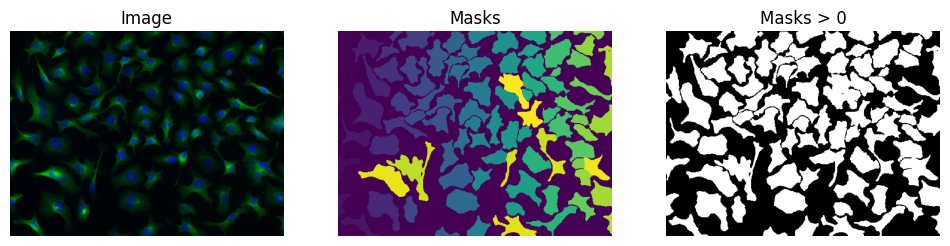

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

ax = axs[0]
ax.imshow(imgs[0].transpose(1, 2, 0))  # change to channel last for display
ax.axis('off')
ax.set_title('Image')

ax = axs[1]
ax.imshow(masks[0])
ax.axis('off')
ax.set_title('Masks')

ax = axs[2]
im = ax.imshow((masks[0] > 0).astype('int'), cmap='gray')
ax.axis('off')
ax.set_title('Masks > 0')

We loop through the labeled cells and remove boundary pixels from each cell mask:

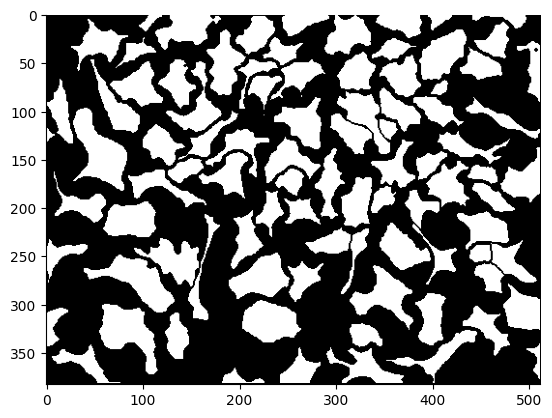

In [11]:
# function to erode boundary pixels. We fill an array with zeros, iterate over our labels, erode them
# and then write them back into our empty array

# to do this efficiently we use only the slices containing the masks
# using 'find_objects'
from scipy.ndimage import binary_erosion, find_objects

def erode(labels, iterations):
    foreground = np.zeros(labels.shape, 'bool')
    slices = find_objects(labels)

    for i, slc in enumerate(slices):
        mask = labels[slc] == (i+1)
        # erode mask
        eroded_mask = binary_erosion(mask, iterations=iterations, border_value=0)
        foreground[slc] += eroded_mask

    return foreground

foreground = erode(masks[0].copy(), 1)
plt.imshow(foreground, cmap='gray')


Let's compute the eroded masks for each image:

In [12]:
foregrounds = np.array([erode(mask.copy(), 1).astype('float32') for mask in masks])
foregrounds_test = np.array([erode(mask.copy(), 1).astype('float32') for mask in masks_test])

Now let's define our training function.

We will use the **AdamW** optimizer to modify our weights to reduce the loss function, which consists of iterating three steps.

1. **Evaluate the loss** on the training data in batches
```python
Y_pred = model(X_batch)
loss = loss_fn(Y_pred, Y_batch)
```
where `X_batch` are a batch of training images, and `Y_batch` are the neuron responses to a batch of training images (tensor of number of stimuli by number of neurons).

We will use `nn.BCEWithLogitsLoss()` as our loss function:
```python
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(Y_pred, Y_batch)
```

2. **Compute the gradient of the loss** with respect to each of the network weights, with the `.backward()` method of the loss `loss`. Note that the gradients of each parameter need to be cleared before calling `.backward()`, otherwise the gradients will accumulate across iterations, with `.zero_grad()`:
```python
optimizer.zero_grad()
loss.backward()
```

3. **Update the network weights** by descending the gradient. In Pytorch, we can do this using built-in optimizers. We'll use the `optim.AdamW` optimizer (documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.AdamW)) which updates parameters along the negative gradient, scaled by a learning rate and scaled by the moving average of the gradients, and with scaled momentum. To optimize *all* the parameters of a network `model` using a learning rate of .001, the optimizer would be initialized as follows
  ```python
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
  ```

  After computing all the parameter gradients in step 2, we can then update each of these parameters using the `.step()` method of this optimizer,
  ```python
  optimizer.step()
  ```

This optimizer [AdamW](https://pytorch.org/docs/stable/optim.html#torch.optim.AdamW) includes `weight_decay` which is an L2 regularization of the weights (reduces the magnitude of the weights on each iteration). Regularization is important to avoid over-fitting.

In [13]:
## define train and validation data
np.random.seed(0)  # set random seed for reproducibility
itrain = np.random.choice(np.arange(len(imgs)), size=int(len(imgs) * 0.85), replace=False)  # random train indices
ival = np.setdiff1d(np.arange(len(imgs)), itrain)  # validation indices

# train and val images
X_train = imgs[itrain]
X_val = imgs[ival]

# train and val targets
Y_train = foregrounds[itrain]
Y_val = foregrounds[ival]
masks_train = masks[itrain]
masks_val = masks[ival]

Train the model, it will take 1-2 min or less on most GPUs.

In [14]:
import time

def train_unet(unet, X_train, Y_train, X_val, Y_val, loss_fn,
               n_epochs=100, batch_size=8, learning_rate=5e-3):
    """Train the U-net model

    Args:
        unet: Unet model
        X_train: training images
        Y_train: training masks
        X_val: validation images
        Y_val: validation masks
        loss_fn: loss function to use (e.g., nn.BCEWithLogitsLoss())
        n_epochs: number of epochs to train (default 100)
        batch_size: size of each training batch (default 8)
        learning_rate: initial learning rate (default 5e-3)
    """
    device = unet.output.weight.device  # get device from unet output layer

    # initialize PyTorch AdamW optimizer
    optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate, weight_decay=1e-4)

    # loop over epochs
    train_loss, val_loss = np.zeros(n_epochs), np.nan * np.zeros(n_epochs)
    ntrain, nval = X_train.shape[0], X_val.shape[0]
    tic = time.time()
    for iepoch in range(n_epochs):
        unet.train() # set model to training mode
        np.random.seed(iepoch)
        iperm = np.random.permutation(ntrain)  # random permutation of stimuli
        if iepoch % 10 == 0 and iepoch > 50:
            learning_rate /= 3 # reduce learning rate by factor of 3 every 10 epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate
        for istart in range(0, ntrain, batch_size):
            X_batch = X_train[iperm[istart : istart + batch_size]]
            Y_batch = Y_train[iperm[istart : istart + batch_size]]

            X_batch, Y_batch = transforms.random_rotate_and_resize(X_batch, Y_batch, scale_range=0.5, xy=(224, 224))[:2]
            # put data on GPU
            X_batch = torch.from_numpy(X_batch).to(device)
            Y_batch = torch.from_numpy(Y_batch).to(device)

            # compute network output from inputs in train_data
            Y_pred = unet(X_batch)

            # evaluate loss function
            loss = loss_fn(Y_pred, Y_batch)

            optimizer.zero_grad() # clear previous gradients
            loss.backward() # compute gradients
            optimizer.step() # update weights

            train_loss[iepoch] += loss.item() # average loss over epoch
        train_loss[iepoch] /= ntrain

        # evaluate val loss
        unet.eval()
        val_loss[iepoch] = 0.0
        with torch.no_grad():
            for istart in range(0, nval, batch_size):
                np.random.seed(0) # same seed for val set augmentations always
                X_batch, Y_batch = transforms.random_rotate_and_resize(X_val[istart : istart + batch_size],
                                                        Y_val[istart : istart + batch_size],
                                                            scale_range=0.5, xy=(224, 224))[:2]
                X_batch = torch.from_numpy(X_batch).to(device)
                Y_batch = torch.from_numpy(Y_batch).to(device)
                Y_pred = unet(X_batch)
                val_loss[iepoch] += loss_fn(Y_pred, Y_batch).item()
            val_loss[iepoch] /= nval

        if iepoch < 10 or iepoch % 5 == 0:
            print(f'epoch {iepoch}, train_loss = {train_loss[iepoch]:0.4f}, val_loss = {val_loss[iepoch]:0.4f}, LR = {learning_rate:.1e}, time {time.time()-tic:.2f}s')

    return train_loss, val_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# declare unet here to reinitialize as needed before training
unet = Unet(n_outputs=1).to(device)

# define loss function
loss_fn = nn.BCEWithLogitsLoss()  # binary cross-entropy loss with logits

# train the model
train_loss, val_loss = train_unet(unet, X_train, Y_train, X_val, Y_val, loss_fn,
                                  n_epochs=100, batch_size=8, learning_rate=5e-3)

# (optional) save the model
torch.save(unet.state_dict(), 'unet_2class.pth')

epoch 0, train_loss = 0.0745, val_loss = 0.0843, LR = 5.0e-03, time 0.78s
epoch 1, train_loss = 0.0583, val_loss = 0.0945, LR = 5.0e-03, time 1.23s
epoch 2, train_loss = 0.0479, val_loss = 0.0873, LR = 5.0e-03, time 1.67s
epoch 3, train_loss = 0.0391, val_loss = 0.0493, LR = 5.0e-03, time 2.09s
epoch 4, train_loss = 0.0315, val_loss = 0.0383, LR = 5.0e-03, time 2.55s
epoch 5, train_loss = 0.0262, val_loss = 0.0313, LR = 5.0e-03, time 2.98s
epoch 6, train_loss = 0.0234, val_loss = 0.0310, LR = 5.0e-03, time 3.43s
epoch 7, train_loss = 0.0190, val_loss = 0.0330, LR = 5.0e-03, time 3.86s
epoch 8, train_loss = 0.0179, val_loss = 0.0284, LR = 5.0e-03, time 4.31s
epoch 9, train_loss = 0.0161, val_loss = 0.0245, LR = 5.0e-03, time 4.73s
epoch 10, train_loss = 0.0154, val_loss = 0.0180, LR = 5.0e-03, time 5.17s
epoch 15, train_loss = 0.0134, val_loss = 0.0168, LR = 5.0e-03, time 7.41s
epoch 20, train_loss = 0.0122, val_loss = 0.0167, LR = 5.0e-03, time 9.61s
epoch 25, train_loss = 0.0124, val_

Plot the training and validation losses across epochs:

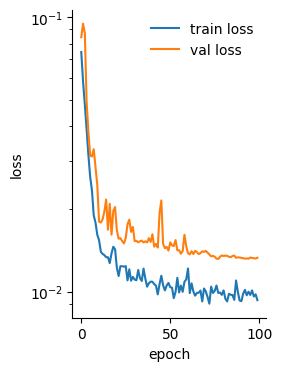

In [15]:
fig, ax = plt.subplots(figsize=(2.5, 4))
ax.plot(train_loss, label='train loss')
ax.plot(val_loss, label='val loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(frameon=False)
ax.set_yscale('log')
ax.set_yticks([1e-2, 1e-1])

**Q: Why is the validation loss higher than the training loss?**

Now we want to estimate the masks, we will need to define a threshold on the cell probability, using the validation images. First we evaluate the network on the validation images, producing the predicted cell probabilities:

X_val_torch shape:  torch.Size([14, 3, 368, 512])
Y_val_pred shape:  (14, 1, 368, 512)


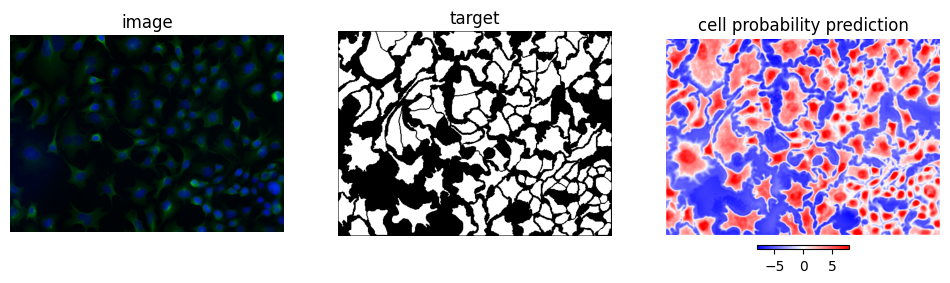

In [16]:
# compute predictions on validation set
with torch.no_grad():
    unet.eval()  # set model to evaluation mode
    # predict on validation set
    X_val_torch = torch.from_numpy(X_val[:, :, :368, :512]).float().to(device)
    print('X_val_torch shape: ', X_val_torch.shape)
    Y_val_pred = unet(X_val_torch).cpu().numpy()
    print('Y_val_pred shape: ', Y_val_pred.shape)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
ax = axs[0]
ax.imshow(X_val[0, :, :368].transpose(1, 2, 0))  # change to channel last for display
ax.axis('off')
ax.set_title('image')
ax = axs[1]
ax.imshow(Y_val[0], cmap='gray')
ax.axis('off')
ax.set_title('target')
ax = axs[2]
ax.imshow(Y_val_pred[0, 0], cmap='bwr', vmin=-8, vmax=8)
ax.axis('off')
ax.set_title('cell probability prediction')
cbar = fig.colorbar(ax.images[0], ax=ax, orientation='horizontal', fraction=0.02, pad=0.04)


Now we threshold the predicted cell probabilities - after thresholding each connected component is assigned as a separate cell id. We loop over these thresholds, choosing the best one based on the average precision score. The average precision is defined as TP / (TP + FP + FN) where TP is true positives, FP is false positives, and FN is false negatives. A function for computing average precision is available in Cellpose ([`metrics.average_precision`](https://github.com/MouseLand/cellpose/blob/9e5cc9cc70fdafe3442e21189d2d4eaf2c87425a/cellpose/metrics.py#L88)).

e:\github\cellpose_dev\cellpose\metrics.py:172: RuntimeWarning: invalid value encountered in divide
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)


Best threshold: 1.26, AP: 0.40


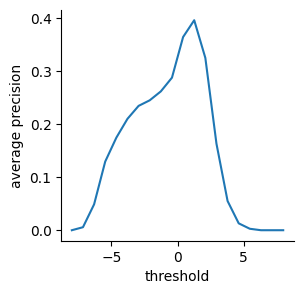

In [17]:
from cellpose import metrics
from scipy.ndimage import label

# loop over thresholds and compute ap
thresholds = np.linspace(-8, 8, 20)  # thresholds to test
ap_scores = np.zeros((len(thresholds), len(ival)))
for i, threshold in enumerate(thresholds):
    masks_val_pred = []
    for j in range(len(ival)):
        # apply threshold to predictions
        cell_pix = (Y_val_pred[j, 0] > threshold).astype('float32')
        masks_pred = label(cell_pix)[0]  # label connected components
        masks_val_pred.append(masks_pred)

    # compute average precision
    ap_scores[i] = metrics.average_precision(list(masks_val[:, :368]), masks_val_pred,
                                             threshold=0.5)[0].squeeze()

threshold = thresholds[ap_scores.mean(axis=1).argmax()]  # find threshold with highest average precision
print(f'Best threshold: {threshold:.2f}, AP: {ap_scores.mean(axis=1).max():.2f}')

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(thresholds, ap_scores.mean(axis=1))
ax.set_xlabel('threshold')
ax.set_ylabel('average precision');


**Q: Why did we crop the validation images by a small amount? You can test this by trying to run the images without cropping.**

(In practical applications, we pad with zeros to produce valid image shapes for the u-net.)

For evaluation, we will use this threshold for the held-out test images:

In [18]:
# compute predictions on test set
with torch.no_grad():
    unet.eval()  # set model to evaluation mode
    # predict on test set
    X_test_torch = torch.from_numpy(np.array(imgs_test)[:, :, :368, :512]).float().to(device)
    print('X_test_torch shape: ', X_test_torch.shape)
    Y_test_pred = unet(X_test_torch).cpu().detach().numpy()
    print('Y_test_pred shape: ', Y_test_pred.shape)

    # apply the best threshold to the predictions
    masks_test_pred = []
    for j in range(len(imgs_test)):
        # apply threshold to predictions
        cell_pix = (Y_test_pred[j, 0] > threshold).astype('float32')
        masks_pred = label(cell_pix)[0]  # label connected components
        masks_test_pred.append(masks_pred)

ap_test_2class = metrics.average_precision(list(masks_test[:, :368]), masks_test_pred,
                                     threshold=0.5)[0].squeeze()

print(f'Test AP: {ap_test_2class.mean():.2f}')

X_test_torch shape:  torch.Size([11, 3, 368, 512])
Y_test_pred shape:  (11, 1, 368, 512)
Test AP: 0.44


Visualize the performance on the test images:

Text(0.5, 1.0, 'true masks')

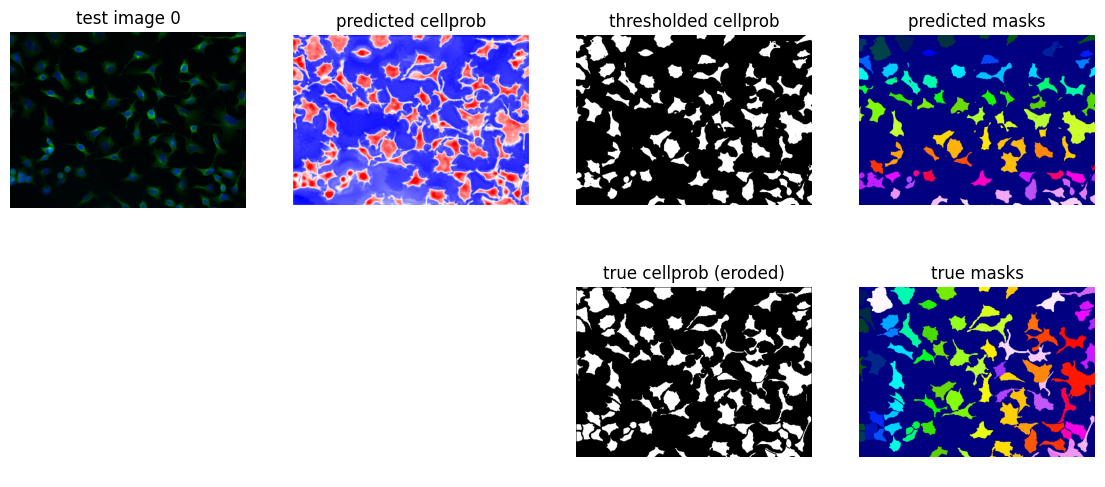

In [ ]:
iex = 0

fig, axs = plt.subplots(2, 4, figsize=(14, 6))
ax = axs[0, 0]
ax.imshow(imgs_test[iex].transpose(1, 2, 0))  # change to channel last for display
ax.axis('off')
ax.set_title(f'test image {iex}')

ax = axs[0, 1]
ax.imshow(Y_test_pred[iex, 0], cmap='bwr', vmin=-8, vmax=8)
ax.axis('off')
ax.set_title(f'predicted cellprob')

ax = axs[0, 2]
im = ax.imshow((Y_test_pred[iex, 0] > threshold).astype('int'), cmap='gray')
ax.axis('off')
ax.set_title(f'thresholded cellprob')

ax = axs[0, 3]
ax.imshow(masks_test_pred[iex], cmap='gist_ncar')
ax.axis('off')
ax.set_title(f'predicted masks')

ax = axs[1, 0]; ax.axis('off');
ax = axs[1, 1]; ax.axis('off');

ax = axs[1, 2]
ax.imshow(foregrounds_test[iex, :368], cmap='gray')
ax.axis('off')
ax.set_title(f'true cellprob (eroded)')

ax = axs[1, 3]
ax.imshow(masks_test[iex, :368], cmap='gist_ncar')
ax.axis('off')
ax.set_title(f'true masks')

# 3. Predicting foreground + background + border pixels

We can see examples of over-merging at cell boundaries, and also that the masks can be smaller than the true masks due to the erosion.

To improve performance we can predict a third class, such as the border pixels for each cell:

(np.float64(-0.5), np.float64(511.5), np.float64(382.5), np.float64(-0.5))

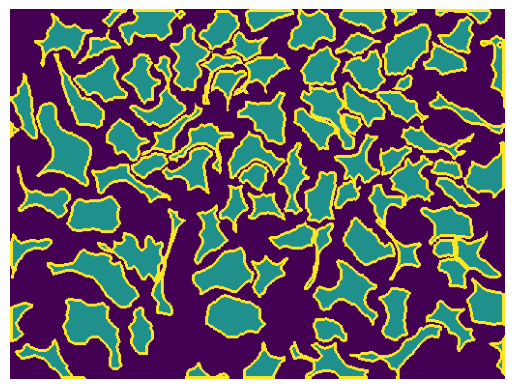

In [20]:
foreground = erode(masks[0].copy(), 3)  # erode by 3 pixels now
border = (foreground == 0) * (masks[0].copy() > 0)
plt.imshow(foreground + 2 * border)
plt.axis('off')

Compute three classes for all images:

In [21]:
foregrounds = np.array([erode(mask.copy(), 3).astype('float32') for mask in masks])
foregrounds_test = np.array([erode(mask.copy(), 3).astype('float32') for mask in masks_test])

boundaries = np.array([(foregrounds[i] == 0) * (masks[i] > 0) for i in range(len(masks))])
boundaries_test = np.array([(foregrounds_test[i] == 0) * (masks_test[i] > 0) for i in range(len(masks_test))])

targets = np.array([foregrounds[i] + 2 * boundaries[i] for i in range(len(masks))])
targets = np.minimum(targets, 2) # ensure targets are [0, 1, 2]
targets_test = np.array([foregrounds_test[i] + 2 * boundaries_test[i] for i in range(len(masks_test))])
targets_test = np.minimum(targets_test, 2) # ensure targets are [0, 1, 2]

Y_train = targets[itrain]
Y_val = targets[ival]

Train on the three classes:

In [22]:
# declare unet here to reinitialize as needed before training
unet = Unet(n_outputs=3).to(device) # 3 classes: foreground, background, boundary

# define loss function
# we use cross-entropy loss for multi-class classification
# we will do weighting based on the class distribution
probs = np.array([(targets == i).mean() for i in range(3)])  # probability of each class
weights = torch.from_numpy(1 / probs).float().to(device) # inverse of probs as weights
def loss_fn(Y_pred, Y_batch):
    """ loss function for multi-class classification """
    if Y_batch.ndim > 3:
        Y_batch = Y_batch.squeeze(1)
    Y_batch = Y_batch.long()  # convert to long for cross-entropy loss
    return nn.CrossEntropyLoss(weight=weights)(Y_pred, Y_batch)

# train the model
train_loss, val_loss = train_unet(unet, X_train, Y_train, X_val, Y_val, loss_fn,
                                  n_epochs=100, batch_size=8, learning_rate=1e-3)

# (optional) save the model
torch.save(unet.state_dict(), 'unet_3class.pth')

epoch 0, train_loss = 0.1288, val_loss = 0.1603, LR = 1.0e-03, time 0.66s
epoch 1, train_loss = 0.1035, val_loss = 0.1511, LR = 1.0e-03, time 1.19s
epoch 2, train_loss = 0.0971, val_loss = 0.1520, LR = 1.0e-03, time 1.67s
epoch 3, train_loss = 0.0925, val_loss = 0.1339, LR = 1.0e-03, time 2.19s
epoch 4, train_loss = 0.0882, val_loss = 0.1278, LR = 1.0e-03, time 2.66s
epoch 5, train_loss = 0.0848, val_loss = 0.1015, LR = 1.0e-03, time 3.18s
epoch 6, train_loss = 0.0821, val_loss = 0.0897, LR = 1.0e-03, time 3.64s
epoch 7, train_loss = 0.0768, val_loss = 0.0878, LR = 1.0e-03, time 4.16s
epoch 8, train_loss = 0.0756, val_loss = 0.0793, LR = 1.0e-03, time 4.64s
epoch 9, train_loss = 0.0729, val_loss = 0.0787, LR = 1.0e-03, time 5.14s
epoch 10, train_loss = 0.0691, val_loss = 0.0750, LR = 1.0e-03, time 5.62s
epoch 15, train_loss = 0.0601, val_loss = 0.0655, LR = 1.0e-03, time 8.14s
epoch 20, train_loss = 0.0541, val_loss = 0.0579, LR = 1.0e-03, time 10.62s
epoch 25, train_loss = 0.0519, val

We will compute the predictions on the validation set again to define thresholds.

X_val_torch shape:  torch.Size([14, 3, 368, 512])
Y_val_pred shape:  (14, 3, 368, 512)


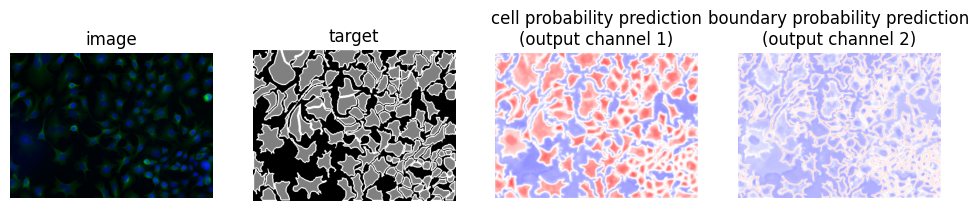

In [23]:
# compute predictions on validation set
with torch.no_grad():
    unet.eval()  # set model to evaluation mode
    # predict on validation set
    X_val_torch = torch.from_numpy(X_val[:, :, :368, :512]).float().to(device)
    print('X_val_torch shape: ', X_val_torch.shape)
    Y_val_pred = unet(X_val_torch).cpu().numpy()
    print('Y_val_pred shape: ', Y_val_pred.shape)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
ax = axs[0]
ax.imshow(X_val[0, :, :368].transpose(1, 2, 0))  # change to channel last for display
ax.axis('off')
ax.set_title('image')

ax = axs[1]
ax.imshow(Y_val[0], cmap='gray')
ax.axis('off')
ax.set_title('target')

ax = axs[2]
ax.imshow(Y_val_pred[0, 1], cmap='bwr', vmin=-8, vmax=8)
ax.axis('off')
ax.set_title('cell probability prediction\n(output channel 1)')

ax = axs[3]
ax.imshow(Y_val_pred[0, 2], cmap='bwr', vmin=-8, vmax=8)
ax.axis('off')
ax.set_title('boundary probability prediction\n(output channel 2)');

Now we will use a more complicated function to construct the masks, thresholding both the cell probability and the boundary pixels. We use the thresholded cell probability pixels to create the initial masks, and then we include boundary pixels which are closest to each initial mask, which results in a dilation of the masks. This is implemented in the Cellpose repository ([`utils.get_masks_unet`](https://github.com/MouseLand/cellpose/blob/9e5cc9cc70fdafe3442e21189d2d4eaf2c87425a/cellpose/utils.py#L477)).

Best cell threshold: 4.44, boundary threshold: -0.89, AP: 0.67


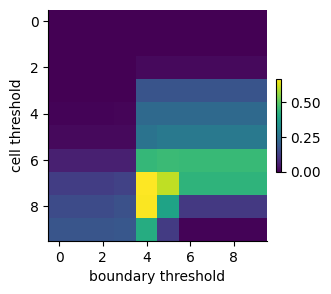

In [24]:
from cellpose import utils

# loop over thresholds and compute ap
cell_thresholds = np.linspace(-8, 8, 10)  # thresholds to test
boundary_thresholds = np.linspace(-8, 8, 10)  # thresholds to test
ap_scores = np.zeros((len(cell_thresholds), len(boundary_thresholds), len(ival)))
for i, cell_threshold in enumerate(cell_thresholds):
    for j, boundary_threshold in enumerate(boundary_thresholds):
        masks_val_pred = []
        for k in range(len(ival)):
            masks_pred = utils.get_masks_unet(Y_val_pred[k].transpose(1, 2, 0),
                                              cell_threshold=cell_threshold, boundary_threshold=boundary_threshold)
            masks_val_pred.append(masks_pred)

        # compute average precision
        ap_scores[i, j] = metrics.average_precision(list(masks_val[:, :368]), masks_val_pred,
                                                threshold=0.5)[0].squeeze()

imax = ap_scores.mean(axis=-1).argmax()  # find index of max average precision
cmax, bmax = np.unravel_index(imax, ap_scores.shape[:2])
cell_threshold = cell_thresholds[cmax]  # best cell threshold
boundary_threshold = boundary_thresholds[bmax]  # best boundary threshold
print(f'Best cell threshold: {cell_threshold:.2f}, boundary threshold: {boundary_threshold:.2f}, AP: {ap_scores.mean(axis=-1).max():.2f}')

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(ap_scores.mean(axis=-1), aspect='auto', cmap='viridis')
ax.set_xlabel('boundary threshold')
ax.set_ylabel('cell threshold')
fig.colorbar(ax.images[0], ax=ax, orientation='vertical', fraction=0.02, pad=0.04)

Now we use these thresholds for the test set:

In [25]:
# compute predictions on test set
with torch.no_grad():
    unet.eval()  # set model to evaluation mode
    # predict on test set
    X_test_torch = torch.from_numpy(np.array(imgs_test)[:, :, :368, :512]).float().to(device)
    print('X_test_torch shape: ', X_test_torch.shape)
    Y_test_pred = unet(X_test_torch).cpu().detach().numpy()
    print('Y_test_pred shape: ', Y_test_pred.shape)

    # use the argmax for the predictions
    masks_test_pred = []
    for j in range(len(imgs_test)):
        # apply threshold to predictions
        masks_pred = utils.get_masks_unet(Y_test_pred[j].transpose(1, 2, 0),
                                          cell_threshold=cell_threshold,
                                          boundary_threshold=boundary_threshold)
        masks_test_pred.append(masks_pred)

ap_test_3class = metrics.average_precision(list(masks_test[:, :368]), masks_test_pred,
                                     threshold=0.5)[0].squeeze()

print(f'Test AP: {ap_test_3class.mean():.2f}')

X_test_torch shape:  torch.Size([11, 3, 368, 512])
Y_test_pred shape:  (11, 3, 368, 512)
Test AP: 0.66


We can see this is an improvement on the 2 class prediction:

Text(0.5, 1.0, '3-class AP: 0.66, 2-class AP: 0.44')

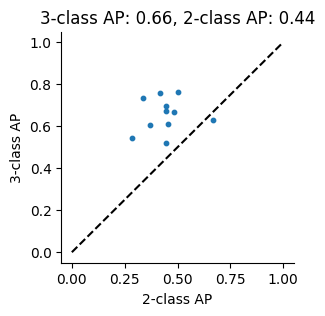

In [26]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(ap_test_2class, ap_test_3class, s=10)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('2-class AP')
ax.set_ylabel('3-class AP')
ax.set_title(f'3-class AP: {ap_test_3class.mean():.2f}, 2-class AP: {ap_test_2class.mean():.2f}')

Visualize the predictions:

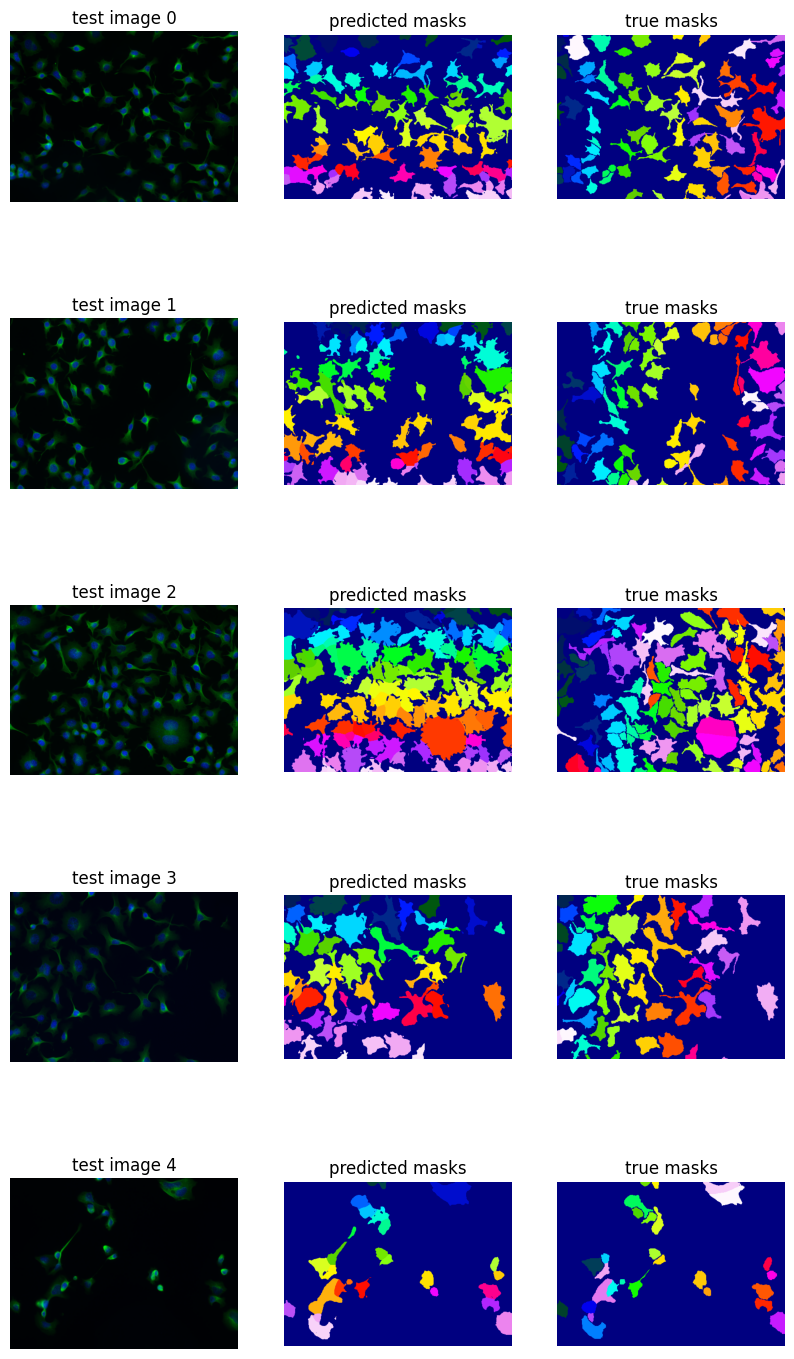

In [27]:
fig, axs = plt.subplots(5, 3, figsize=(10, 18))
for i in range(5):
    ax = axs[i, 0]
    ax.imshow(imgs_test[i].transpose(1, 2, 0))  # change to channel last for display
    ax.axis('off')
    ax.set_title(f'test image {i}')

    ax = axs[i, 1]
    ax.imshow(masks_test_pred[i], cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(f'predicted masks')

    ax = axs[i, 2]
    ax.imshow(masks_test[i, :368], cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(f'true masks')

# 4. Predicting cellpose flows representation

Now let's try out the Cellpose flows for prediction:

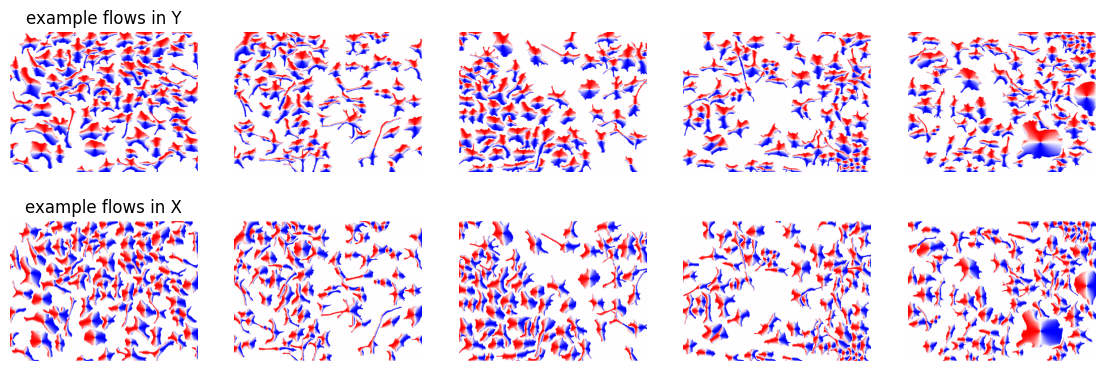

In [28]:
from cellpose import dynamics

flows = [dynamics.masks_to_flows_gpu(masks[i], device=device) for i in range(len(masks))]

fig, axs = plt.subplots(2, 5, figsize=(14, 4.5))
for i in range(5):
    ax = axs[0, i]
    ax.imshow(flows[i][0], cmap='bwr', vmin=-1, vmax=1)
    ax.axis('off')
    if i==0:
        ax.set_title('example flows in Y')

    ax = axs[1, i]
    ax.imshow(flows[i][1], cmap='bwr', vmin=-1, vmax=1)
    ax.axis('off')
    if i==0:
        ax.set_title('example flows in X')


In Cellpose we use a `nn.BCEWithLogitsLoss` for the cell probability prediction and `nn.MSELoss` for the flow prediction. We will test the built-in Cellpose model as it has been trained on much more data for far longer. The latest Cellpose model also uses a vision transformer as its backbone (initialized from [Segment Anything](https://segment-anything.com/)).

In [ ]:
from cellpose import models, io

io.logger_setup() # initialize logging
model = models.CellposeModel(gpu=True)
masks_test_pred, flows_test_pred, _ = model.eval(list(imgs_test))

Now we will compute the performance on the test images:

In [30]:
ap_test_cellpose = metrics.average_precision(list(masks_test), masks_test_pred,
                                     threshold=0.5)[0].squeeze()

print(f'Test AP: {ap_test_cellpose.mean():.2f}')

Test AP: 0.94


Our performance is even better than the 3-class model:

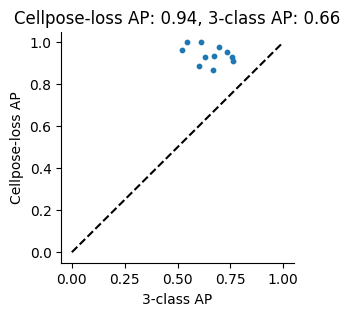

In [31]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(ap_test_3class, ap_test_cellpose, s=10)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('3-class AP')
ax.set_ylabel('Cellpose-loss AP')
ax.set_title(f'Cellpose-loss AP: {ap_test_cellpose.mean():.2f}, 3-class AP: {ap_test_3class.mean():.2f}');

Visualize the predictions:

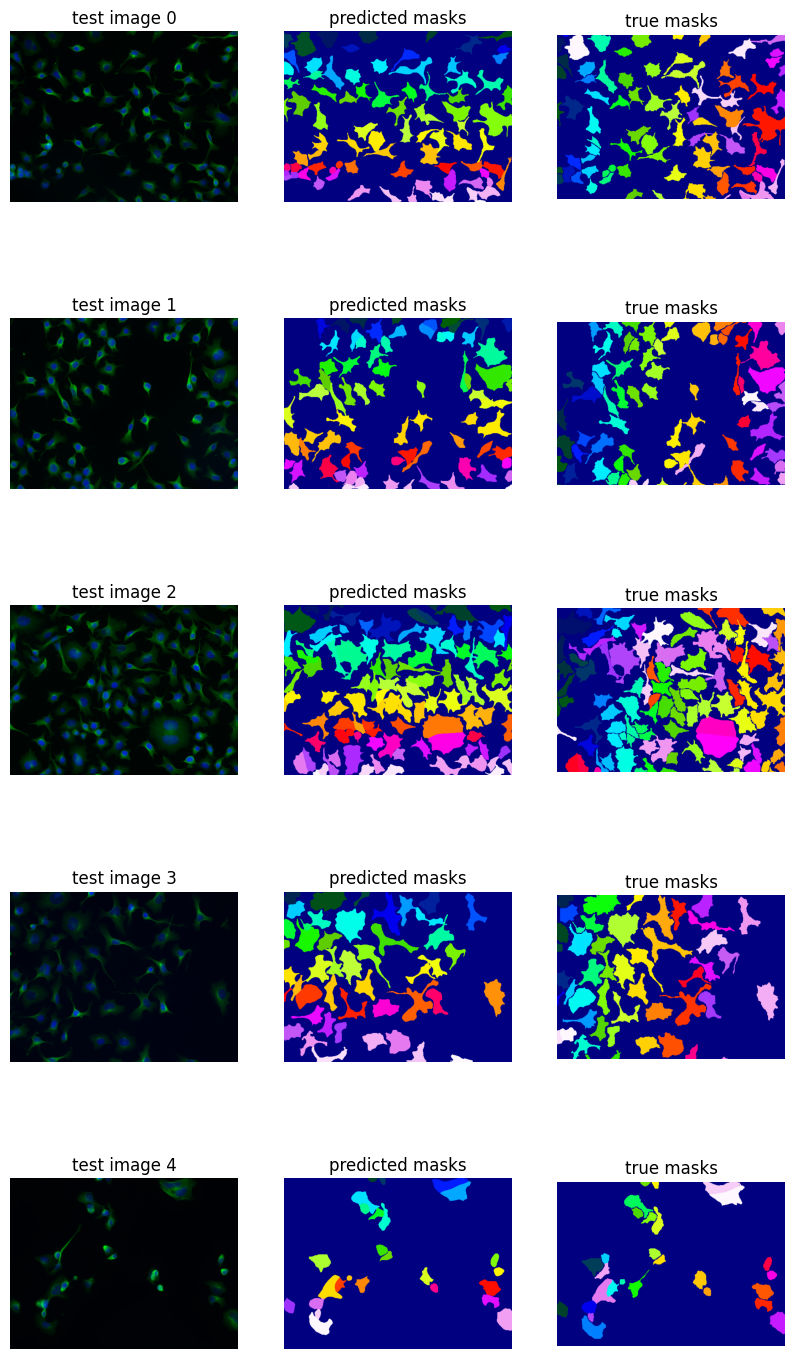

In [32]:
fig, axs = plt.subplots(5, 3, figsize=(10, 18))
for i in range(5):
    ax = axs[i, 0]
    ax.imshow(imgs_test[i].transpose(1, 2, 0))  # change to channel last for display
    ax.axis('off')
    ax.set_title(f'test image {i}')

    ax = axs[i, 1]
    ax.imshow(masks_test_pred[i], cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(f'predicted masks')

    ax = axs[i, 2]
    ax.imshow(masks_test[i, :368], cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(f'true masks')

**Q: What are the differences between the predicted masks from the 3-class u-net versus the Cellpose model? What aspects of the loss function might contribute to the differences that you see?**

## Acknowledgments

Some of this material was adapted from the Neuromatch Deep Learning Day [tutorials](https://compneuro.neuromatch.io/tutorials/W1D5_DeepLearning/student/W1D5_Tutorial1.html) by Jorge Menendez and Carsen Stringer; and from the AI@MBL Instance Segmentation Day [tutorial](https://github.com/ai-mbl/instance_segmentation/tree/c6183657e3282faebfe42abf2ff36bb5a3e5b554) by Arlo Sheridan.